In [37]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
"""
# oe_bls_cex_pumd

See the markdown file named oe_bls_cex_EDA.md for definitions and key concepts needed
to understand this processing.

The functions here:

    oe_bls_cex_pumd_download  -  downloads the PUMD data files for a list of years
    oe_bls_cex_pumd_read      -  loads those files into python and pandas data structures
    oe_bls_cex_pumd_metadata  -  reads the metadata (Hierachical Grouping & Variable Dictionary)
    oe_bls_cex_pumd_interpret -  processes to calculate the output datafram: spending categories by Consumer Unit
    oe_bls_cex_pumd_check     -  tests results against MSA and State BLS publications
    oe_bls_cex_pumd_write     -  generates resulting output to files

"""

import pandas as pd
import numpy as np
from datetime import datetime
import wget
import zipfile
import os
import warnings
warnings.simplefilter("ignore")

def oe_bls_cex_pumd_download(years, pumddir = './pumd/', cexurl='https://www.bls.gov/cex/'):
    """
    This function downloads the files, dictionaries and hierarchical groupings of in
    Bureau of Labor Statistics (BLS), Consumer Expenditure Survey's (CEX) Public Use 
    Microsample Data (PUMD). Adjustments and corrections to this source are applied by
    the related oe_bls_cex_pumd_read function.
        
    :param  years:    a list of 4 digit years that are strings like ['2018','2019','2020'] 
    :param  pumddir:  a string with the path destination of the download & unzipped files 
    :param  cexurl:   the root URL for the Consumer Expenditure Survey

    :return None   The function either succeeds or fails
    """
    
    # Avoid conflicts with any previously downloaded
    if os.path.exists(pumddir):
        print("Destination directory '"+pumddir+"already exists.")
        print("Please remove it or select a new destination directory.")
        raise
    else:
        os.mkdir(pumddir)

    # Download and reformat the HGs as a dictionary of dataframes
    for yr in years:
        for fn in ('diary','intrvw'):
            # download
            print('Downloading',yr,fn)
            wget.download(cexurl+'pumd/data/comma/'+fn+yr[2:]+'.zip',
                          out=pumddir,
                          bar=None)
            # unzip
            with zipfile.ZipFile(pumddir+fn+yr[2:]+'.zip', 'r') as zip_ref:
                zip_ref.extractall(pumddir)
            
    # also need the HG file.  It is a zip of all years.
    print('Downloading Hierarchical Grouping file')
    wget.download(CEXURL+'pumd/stubs.zip', 
                  out=PUMDDIR,
                  bar=None)
    with zipfile.ZipFile(PUMDDIR+'stubs.zip', 'r') as zip_ref:
        zip_ref.extractall(PUMDDIR)

    # Get the PUMD dictionary
    print('Getting the PUMD dictionary')
    wget.download(CEXURL+'pumd/ce_pumd_interview_diary_dictionary.xlsx',
                  out=PUMDDIR,
                  bar=None)

    return None

def oe_bls_cex_pumd_read(years, pumddir = './pumd/', weights=False):
    """
    This function reads the PUMD data files of the dataset into python data structures. 

    :param  years: a list of 4 digit years that are strings     ['2018','2019','2020'] 
    :param  UCCs: a list of UCCs, six digit as strings     ['123456','234567','345678']

    pumdfiles: a dictionary, by year, with the file based dataframes
    hg: the Hierarchical Grouping table with linenum, level, title, survey, factor.
    vardict: provides a dictionary of the variables (not UCCs) in the PUMD
    codedict: provides a table with a description for each coded value in the PUMD

    :return  pumdfiles, hg, vardict, codedict
    """
    
    filetypes = ['dtbd','dtid','expd','fmld','memd','fmli','itbi','itii','memi','mtbi','ntax']

    filereads = {}
    for t in filetypes:
        filereads[t] = []

    for yr in years:
        for fn in ('diary','intrvw'):
            print("Reading",yr,fn)
            # Sometimes the intrv folder is in another subdir  intrvw17/intrvw17/*.csv eg
            if ((fn == 'intrvw') & (os.path.exists(pumddir+fn+yr[-2:]+ "\\"+fn+yr[-2:]+"\\"))):
                folder = fn+yr[-2:]+ "\\"+fn+yr[-2:]+"\\"
            else:
                folder = fn+yr[-2:]+ "\\"
            for f in os.listdir(pumddir+folder):
                ftype = f[0:4]
                if ftype in filetypes:
                    fdf = pd.read_csv(pumddir+folder +f, dtype=object)
                    fdf.columns = [c.upper() for c in fdf.columns]
                    fdf["filename"] = f
                    fdf["year"] = yr
                    filereads[ftype].append(fdf)

        # Ensure that the yearly versions have the same column names
        for t in filetypes:
            for f in filereads[t]:
                if list(f.columns).sort() != list(filereads[t][0].columns).sort():
                    print("Columns inconsistent",t)
            
        pumd = {}
        for t in filetypes:
            pumd[t] = pd.concat(filereads[t])   
    
    print('Reading the Hierarchical Groupings')
    # I'll use the Integrated HG.  Its mostly a superset of Interview & Diary HG less a dozen each
    hg = {}
    hgdtypes = {"linenum":int, "level":str, "title":str, "ucc":str, "survey":str, "factor":str, "group":str}
    for yr in years:
        h = pd.read_fwf(PUMDDIR+'stubs\\CE-HG-Integ-'+yr+'.txt', index_col=False,
        names =    ["linenum", "level",  "title",     "ucc",     "survey",  "factor",  "group"],
        colspecs = [(0, 3),     (3, 6),  (6, 69),  (69, 77),     (82, 85),  (85, 88),  (88,95)],
        dtype=hgdtypes)    
        # Rows with linenum == 2 are just title text that wrapped from the previous row.
        for i,r in h.iterrows():
            if r.linenum == 2:
                h.at[i-1,'title'] = h.at[i-1,'title']+' '+r.title
        hg[yr] = h[h.linenum == 1]
     
    print('Reading the Dictionary')
    # The sheet names can varying capitalization and include spaces
    xl = pd.ExcelFile(PUMDDIR + 'ce_pumd_interview_diary_dictionary.xlsx')
    varsheet =  [c for c in xl.sheet_names if 'vari' in c.lower()][0]
    codesheet = [c for c in xl.sheet_names if 'code' in c.lower()][0]

    vardict =   pd.read_excel(PUMDDIR + 'ce_pumd_interview_diary_dictionary.xlsx',
                              sheet_name = varsheet)
    codedict =  pd.read_excel(PUMDDIR + 'ce_pumd_interview_diary_dictionary.xlsx',
                              sheet_name = codesheet)

    # filter the vardict sheet to only those where 
    #     you year of interest is > First Year > First Quart and < Last Year <Last Quarter

    return  pumd, hg, vardict, codedict


def oe_bls_cex_pumd_interpret(pumd, vardict, rules, year, weights=False):
    """
    This function applies adjustments, logical rules and corrections to this source
    are applied by the related oe_bls_cex_pumd_read function.to PUMD data structures. 

    :param  years: a list of 4 digit years that are strings     ['2018','2019','2020'] 
    :param  UCCs: a list of UCCs, six digit as strings     ['123456','234567','345678']

    pumdfiles: a dictionary, by year, with the file based dataframes
    hg: the Hierarchical Grouping table with linenum, level, title, survey, factor.
    vardict: provides a dictionary of the variables (not UCCs) in the PUMD
    codedict: provides a table with a description for each coded value in the PUMD
    
    The processing logic replicates what the BLS' own SAS (& R) program does!
    See:    https://www.bls.gov/cex/pumd-getting-started-guide.htm
            https://www.bls.gov/cex/pumd-getting-started-guide.htm#section5
            https://www.bls.gov/cex/pumd/sas-ucc.zip
            https://www.bls.gov/cex/pumd/r-ucc.zip
            
    This is also helpful 
            https://www.bls.gov/cex/pumd_doc.htm
            https://www.bls.gov/cex/csxintvw.pdf
            https://www.ilo.org/surveyLib/index.php/catalog/1193/download/8310
            
    :return family:  a dataframe keyed by CU (NEWID) 
    :return expend:  a dataframe keyed by CU & UCC 
    :return pubfile: a join between family, expend 
    """

    print("Processing PUMD for", year)

    # UPPERCASE variables are the BLS orignal variable names
    # lowercase variables are calculated in this process
    
    # Get family dataframes for Interview and Diary
    fmli = pumd['fmli'][pumd['fmli'].year == year]
    fmld = pumd['fmld'][pumd['fmld'].year == year]
    # Get member level dataframes
    mtbi = pumd['mtbi'][pumd['mtbi'].year == year]
    expd = pumd['expd'][pumd['expd'].year == year]

    # column name lists
    wtrep = [("WTREP"+str(i+1).zfill(2)) for i in range(44)]+["FINLWT21"] ## WTREP01-REPWT444 and FINL
    repwt = [("REPWT"+str(i+1)) for i in range(45)]  # REPWT1-REPWT45
    rcost = [("RCOST"+str(i+1)) for i in range(45)]  # RCOST1-RCOST45

    # Process Family

    # Sometimes QINT dates are meaningless, drop these 
    fmli = fmli.where(~fmli.QINTRVMO.isna())
    fmli = fmli.where(~fmli.QINTRVYR.isna())
    
    def mo_scope(row):
        if   (row["QINTRVMO"] in ['01','02','03']) & (row["QINTRVYR"]==year):
            return (int(row["QINTRVMO"]) - 1)
        elif (row["QINTRVMO"] in ['01','02','03']) & (row["QINTRVYR"]==str(int(year)+1)):
            return (4 - int(row["QINTRVMO"]))
        else:
            return 3

    fmli["income"] = fmli["FINCBTXM"]  # fmld has a different var for income bef taxes
    fmli["source_family"] = 'I'
    fmli['mo_scope'] = fmli.apply(mo_scope, axis=1)
    
    fmld["income"] = fmld["FINCBEFM"] # fmli has a different var for income bef taxes
    fmld["source_family"] = "D"
    fmld["mo_scope"] = 3
    
    if weights:
        for i in range(45):
            fmli[wtrep[i]] = fmli[wtrep[i]].astype(float).fillna(0)
            fmli[repwt[i]] = (fmli[wtrep[i]] * fmli["mo_scope"]) / 12
            fmld[wtrep[i]] = fmld[wtrep[i]].astype(float).fillna(0)    
            fmld[repwt[i]] = (fmld[wtrep[i]] * fmld["mo_scope"]) / 12
    else:
        fmli['repwt'] = (fmli["FINLWT21"].astype(float).fillna(0) * fmli["mo_scope"]) / 12
        fmld['repwt'] = (fmld["FINLWT21"].astype(float).fillna(0) * fmld["mo_scope"]) / 12

    fmli = fmli.reset_index(drop=True)
    fmld = fmld.reset_index(drop=True)
    fmlcols = [c for c in fmli.columns if c in fmld.columns] # 272 columns
    if weights:
        fmlcols = [c for c in fmli.columns if c in wtrep[:-1]]
    family = pd.concat([fmli[fmlcols],fmld[fmlcols]], axis=0)

    # Process flag fields   _ values of A,B,C are NAs
    print("Processing flag fields")
    def flag_NAs(row,flagged,flagcol):
        if row[flagcol] in ["A","B","C"]:
            return np.NaN
        else:
            return row[flagged]
        return None

    flags = {}
    flag_candidates = vardict[["Variable Name","Flag name"]][~vardict["Flag name"].isna()].drop_duplicates()
    for i,r in flag_candidates.iterrows():
        if (r["Variable Name"] in family.columns) & (r["Flag name"] in family.columns):
            flags[r["Variable Name"]] = r["Flag name"]

    for col in flags.keys():
        # print("    ",col,"flagged by",flags[col])
        family[col] = family.apply(lambda row: flag_NAs(row,col,flags[col]), axis=1)
    
    family.drop([c for c in flags.values()], axis=1, inplace=True)
    
    fmlcols = family.columns  # reset this list
        
    # Process Expend

    mtbi["source_expend"] = "I"
    mtbi = mtbi[(mtbi["REF_YR"] == year) & (mtbi["PUBFLAG"] == "2")]

    expd["source_expend"] = "D"
    expd["COST"] = pd.to_numeric(expd["COST"], errors='coerce')
    expd["COST"] = expd["COST"].astype(float).fillna(0) * 13
    expd = expd[expd["PUB_FLAG"] == "2"]

    expcols =['NEWID','source_expend','UCC','COST'] #,'REF_YR'
    expend = pd.concat([mtbi[expcols],expd[expcols]], axis=0)

    pubfile = pd.merge(family, expend, on='NEWID', how='inner')
    
    pubfile["COST"] = pubfile["COST"].astype(float).fillna(0)
    if weights:
        for i in range(45):
            pubfile[rcost[i]] = pubfile[wtrep[i]] * pubfile["COST"]
    else:
        pubfile['rcost'] = pubfile["FINLWT21"].astype(float).fillna(0) * pubfile["COST"]

    #
    # Sum the raw data up to CUID
    #

    cucols = ["CUID",
              "POPSIZE","BLS_URBN",    # Pop density
              "CUTENURE",              # Household tenure (yrs in this residence)
              "AGE_REF",               # Age of the CU reference contact
              "PSU","STATE",           # Geographies
              "CHILDAGE",              # Presence of children if > 0
              "FAM_SIZE",
              "income",                # Household annual income before taxes, imputed
              "REF_RACE",              # Race if the CU reference contact
              "EDUC_REF"              # .isin(['14','15','16'])  means college degree or better
             ]
    
    family['CUID'] = family['CUID'].str.zfill(7)
    expend['CUID'] = expend.NEWID.str[:7]
    cu = family.groupby("CUID")[cucols].first()

    # There are 851 CUs that did not report any UCC level costs
    # len(set(expend.CUID)-set(family.CUID))
    # 0
    # len(set(family.CUID)-set(expend.CUID))
    # 851
    
    #pubfile.groupby(['CUID','UCC']).sum()[["COST","rcost"]].reset_index()
    temp = pubfile.groupby(['CUID','UCC']).sum()[["COST"]].reset_index()
    costs = temp.pivot(index="CUID",columns="UCC", values="COST").reset_index().fillna(0)
    
    #
    # Calculate the summary variables using rules from the HG
    #
    print("Calculating summary variables")

    # ensure all potential UCCs have columns for summary rules
    for c in ( set(hg[hg.ucc.str.isnumeric()].ucc) - set(costs.columns) ):
        costs[c] = 0

    # Apply the rules, creating summary columns
    for level in [9,8,7,6,5,4,3,2]:
        for i, rule in rules[rules.level == level-1].iterrows():
            costs[rule["name"]] = costs[rule["rule"]].sum(axis=1)
        
    return pubfile, family, expend, fmli, fmld, mtbi, expd, costs, cu


def oe_bls_cex_pumd_metadata(hg,vd,cd,year):
    """
    This function interprets PUMD metadata objects, 
    selecting rows applicable to the selected year.
    
    :param hg: A dictionary by year of Hierarchical Grouping dataframes
    :param vd: The Variables dataframe from the PUMD Dictionary
    :param cd: The Codes dataframe from the PUMD Dictionary
    
    :return h,v,c: the current year dataframe of each of the parameters
    """
    print("Narrowing metadata to", year)
    
    # Interpret the Hierarchical Grouping
    h = hg[year]
    
    # Generate the summarization rules from HG
    h["level"] = h["level"].astype(int)
    sumdict = {}
    sumrules = {}
    for level in [9,8,7,6,5,4,3,2]:
        for i,g in h[h.level.isin([level, level-1])].iterrows():        
            if g.level == level-1:
                rule = g.ucc
                sumdict[rule] = level-1
                sumrules[rule] = []
            else:
                sumrules[rule].append(g.ucc)

    emptyrules = [r for r in sumrules.keys() if len(sumrules[r]) == 0]
    for rule in emptyrules:
        sumrules.pop(rule)
        sumdict.pop(rule)

    # Test the rules
    for rule in sumrules.keys():
        if (len(sumrules[rule]) > 0) & (rule.isnumeric()):
            print('invalid rule',rule,': members but numeric')
        if (len(sumrules[rule]) == 0) & (not rule.isnumeric()):
            print('invalid rule',rule,': no members but not numeric')

    # Apply the rules from the bottom up
    r = pd.DataFrame.from_dict({'name':  list(sumdict.keys()),
                                'level': [sumdict[r] for r in sumdict.keys()],
                                'rule':  [sumrules[r] for r in sumdict.keys()]})
    
    # Interpret the Variable Dictionary
    # Final year is empty for current definitions
    vd["Last year"] = vd["Last year"].fillna(datetime.now().year+1)
    v = vd[(int(yr) >= vd["First year"] ) & (int(yr) <= vd["Last year"] )]
    
    # Interpret the Code Dictionary
    cd["Last year"] = cd["Last year"].fillna(datetime.now().year+1)
    c = cd[(int(yr) >= cd["First year"] ) & (int(yr) <= cd["Last year"] )]
    
    return v,c,h,r


def oe_bls_cex_pumd_check(df, year):
    """
    This function compares the interpreted PUMD results against
    MSA and State totals.
    """
    return True


def oe_bls_cex_pumd_write(df, year):
    """
    This function writes a final dataframe to file.
    """
    print("Writing to "+year+" blockgroupspending file")
    df.to_csv(year+'blockgroupspending.csv', index=False)
    return None


if __name__ == "__main__":
    
    # Capitalized variables are globals or multi-year storage
    # Lowercase variables are those for a given working year
    
    CEXURL = 'https://www.bls.gov/cex/'
    PUMDDIR = "D:\\Open Environments\\data\\bls\\cex\\pumd\\"
    YEARS = ['2018'] # ['2016','2017','2018','2019','2020']
    
    #oe_bls_cex_pumd_download(YEARS, pumddir = PUMDDIR, cexurl=CEXURL)
    
    PUMD, HG, VARDICT, CODEDICT = oe_bls_cex_pumd_read(YEARS, pumddir = PUMDDIR)
    
    for yr in YEARS: 
        vardict, codedict, hg, rules = oe_bls_cex_pumd_metadata(HG,VARDICT,CODEDICT,yr)
        pubfile, family, expend, fmli, fmld, mtbi, expd, costs, cu  = \
            oe_bls_cex_pumd_interpret(PUMD,vardict,rules,yr,weights=False)
        #oe_bls_cex_pumd_write(family,yr)

    # more than half of PSU are NA
    MSA = pd.read_csv("MSACodes.csv")
    states = pd.read_csv("https://raw.githubusercontent.com/OpenEnvironments/core/main/states.csv")
    divisions = states[['CensusDivisionName','CensusDivisionCode']].drop_duplicates().dropna()

    print("Done")

Reading 2018 diary
Reading 2018 intrvw
Reading the Hierarchical Groupings
Reading the Dictionary
Narrowing metadata to 2018
Processing PUMD for 2018
Processing flag fields
level 9
level 8
level 7
level 6
level 5
level 4
level 3
level 2
Done


In [ ]:
# Use the flag,var pairs from the vardict
# Apply the flag rules to the expend dataframe as well
# Check that the CUChars are repeated across NEWID

In [ ]:
To get to the CU level, annual aggregate:
    FMLI 
        sum expenses by CUID for REF_YR
        average CUCHARS and INCOME for REF_YR
        * FMLI keyed by NEWID, quarterly obs, sum for REF_YR

    FMLD
        average CUCHARS and INCOME for REF_YR
        sum expenses by CUID for REF_YR
            times a seasonal adjustment, time 26 etc?
        * FMLD is keyed by NEWID "" weekly obs

    EXPD
        average CUCHARS and INCOME for REF_YR
        sum expenses by CUID for REF_YR
            times a seasonal adjustment, time 26 etc?
        * ALLOC is like ALCNO below - used when 1 purchas amount is allocated across mult UCCs

    MTBI
        Monthly, check and see
        sum months by CU,UCC
        NEWID, SEQNO, ALCNO, UCC, RTYPE, EXPNAME, UCCSEQ, REF_MO, REF_YR	
        SEQNO is assigned sequentially during the interview as each expenditure record is recorded into the database.
        ALCNO is assigned sequentially for each record that has been allocated from one expenditure. For example, a CU may report spending $50 on a pair of men's pants and a shirt. The CE program will allocate out that record into two separate records, one for men's pants and shorts ($30) and one for men's shirts ($20).
        what is RTYPE, EXPNAME        
        
"Interview data"
   Expense UCCs refers to weekly amount for two weeks (how to seasonally adjust?)
   Income and Characteristics refer to annual amounts (? average the obs?)

        sum 
        

In [90]:
sum the records up to year by CU
    across quarters, sum biweek then x 26?
create a group by CU x UCC
transpose it UCC is columns




level 9
OWVMIS is sum ['320613', '990940']
level 8
OWNMIS is sum ['320612', '990930']
RNTMIS is sum ['320611', '990920', '790690']
OWVREP is sum ['240113', '240123', '240214', '240223', '240313', '240323', 'OWVMIS', '320633']
OWVMNA is sum ['230902', '340912']
level 7
BREAD is sum ['020110', '020210']
CRAKCO is sum ['020510', '020610']
OTHBAK is sum ['020310', '020410', '020620', '020710', '020820']
ROAST is sum ['030210', '030310', '030410']
STEAK is sum ['030510', '030610', '030710']
HAM is sum ['040310', '040610']
LNCHME is sum ['050210', '050310']
LAMBOT is sum ['050410', '050900']
CHICKE is sum ['060110', '060210']
FRZNFR is sum ['130110', '130121', '130122']
CANDVE is sum ['140210', '140220', '140230', '140320', '140330', '140340', '140310', '140410', '140420']
FRZNPR is sum ['180210', '180220']
SNACKS is sum ['180310', '180320']
CONDMN is sum ['180410', '180420', '180510', '180520']
OTHRPR is sum ['180611', '180612', '180620', '180710', '180720']
COFFEE is sum ['170310', '170410

In [ ]:
recall that WTs are population counts to
    weight the CU level est to a national total
    WT = how many people does this observation represent?


CREATE TABLE POP AS
SELECT source, SUM(REPWT1) AS RPOP1 ... SUM(REPWT45) AS RPOP45
from pubfile
group by source.
;

# AGG is I/D, UCC
CREATE TABLE AGG AS
select source,UCC
  SUM(RCOST1-45)
group by source, UCC

CREATE TABLE AVGS1
	MERGE 	AGG, POP; 
	BY SOURCE; 
 	MEAN1-45 = (RCOST1-45 / RPOP1-45);

CREATE TABLE AVGS2
  select SUM(MEAN1-45)
  group by UCC

--------------------------------------------------------------------
so 
    POP   is I/D with population 1-45 across
    AGG	  is I/D with costs 1-45 across 
    AVGS1 is I/D with cost weights across

In [ ]:
/***************************************************************************/
  /* PROGRAM NAME:  CEX INTEGRATED SURVEYS SAMPLE PROGRAM (SAS)              */
  /* FUNCTION: CREATE A WEIGHTED CALENDAR YEAR AVERAGE EXPENDITURE           */
  /*           FOR A SPECIFIED GROUP OF UCC's                                */
  /*                                                                         */
  /*                                                                         */
  /***************************************************************************/

  /***************************************************************************/
  /* STEP1: SET PARAMETERS                                                   */
  /***************************************************************************/

  /*ENTER DATA YEAR*/
    %LET YEAR = 2018;
  /* ENTER SURVEY SOURCE FOR WHICH YOU WISH TO ESTIMATE FROM (INTERVIEW, DIARY, INTEGRATED)*/
	%LET ESTIMATE = INTEGRATED;
  /* ENTER THE UCCs YOU WISH TO ESTIMATE FOR*/
	%LET UCC = ('470111'); 
  /* ENTER A NAME FOR THE ESTIMATE BEING CREATED*/
	%LET AGG = GASOLINE;
 
	%LET YR1 = %SUBSTR(&YEAR, 3, 2);
	%LET YR2 = %SUBSTR(%EVAL(&YEAR + 1), 3, 2);
  /*ENTER LOCATION OF THE UNZIPPED MICRODATA FILE*/
    %LET DRIVE = C:\2018_CEX;

	LIBNAME I&YR1 "&DRIVE\INTRVW&YR1";
	LIBNAME D&YR1 "&DRIVE\DIARY&YR1";


  /***************************************************************************/
  /* STEP2: READ IN ALL NEEDED DATA                                          */
  /* ----------------------------------------------------------------------- */
  /* 1 READ IN THE INTERVIEW AND DIARY FMLY FILES & CREATE MO_SCOPE VARIABLE */
  /* 2 READ IN THE INTERVIEW MTAB/ITAB AND DIARY EXPN/DTAB FILES             */
  /* 3 MERGE FMLY AND EXPENDITURE FILES TO DERIVE WEIGHTED EXPENDITURES      */
  /***************************************************************************/


DATA FMLY (KEEP= NEWID QINTRVYR QINTRVMO WTREP01-WTREP44 FINLWT21 REPWT1-REPWT45 MO_SCOPE SOURCE);

SET D&YR1..FMLD&YR1.1 (IN = DIARY)
    D&YR1..FMLD&YR1.2 (IN = DIARY)
    D&YR1..FMLD&YR1.3 (IN = DIARY)
    D&YR1..FMLD&YR1.4 (IN = DIARY)

    I&YR1..FMLI&YR1.1x (IN = INTERVIEW)
    I&YR1..FMLI&YR1.2  (IN = INTERVIEW)
    I&YR1..FMLI&YR1.3  (IN = INTERVIEW)
    I&YR1..FMLI&YR1.4  (IN = INTERVIEW)
    I&YR1..FMLI&YR2.1  (IN = INTERVIEW);

	BY NEWID;

	ESTIMATE = "&ESTIMATE.";

	ARRAY REPS_A(45) WTREP01-WTREP44 FINLWT21;
    ARRAY REPS_B(45) REPWT1-REPWT45;

	IF INTERVIEW AND ESTIMATE IN ("INTERVIEW","INTEGRATED") THEN DO;
		SOURCE = 'I';
		IF QINTRVMO IN ('01','02','03') AND QINTRVYR = &YEAR. THEN MO_SCOPE = (QINTRVMO - 1);
    		ELSE IF QINTRVMO IN ('01','02','03') AND QINTRVYR = &YEAR. + 1 THEN MO_SCOPE = (4 - QINTRVMO);
    			ELSE MO_SCOPE = 3;

 		DO i = 1 TO 45;
	  	IF REPS_A(i) > 0 THEN REPS_B(i) = (REPS_A(i) * MO_SCOPE / 12);
		END;	
				OUTPUT;
				END;

	IF DIARY AND ESTIMATE IN ("DIARY","INTEGRATED") THEN DO;
		SOURCE = "D";
		MO_SCOPE = 3;

	DO i = 1 TO 45;
	  	IF REPS_A(i) > 0 THEN REPS_B(i) = (REPS_A(i) * MO_SCOPE / 12);
		END;	

				OUTPUT;
				END;

	
	  IF QINTRVYR  THEN 
        SOURCE = 'I';
	  IF WEEKI THEN 
        SOURCE = 'D';

RUN;

DATA EXPEND (KEEP= NEWID SOURCE UCC COST REF_YR);

  SET D&YR1..EXPD&YR1.1 (IN = DIARY)
      D&YR1..EXPD&YR1.2 (IN = DIARY)
      D&YR1..EXPD&YR1.3 (IN = DIARY)
      D&YR1..EXPD&YR1.4 (IN = DIARY)

      I&YR1..MTBI&YR1.1X (IN = INTERVIEW)
      I&YR1..MTBI&YR1.2  (IN = INTERVIEW)
      I&YR1..MTBI&YR1.3  (IN = INTERVIEW)
      I&YR1..MTBI&YR1.4  (IN = INTERVIEW)
      I&YR1..MTBI&YR2.1  (IN = INTERVIEW);
	
  ESTIMATE = "&ESTIMATE.";
  IF UCC IN &UCC.;       

	IF INTERVIEW AND ESTIMATE IN ("INTERVIEW") THEN DO;
		SOURCE = 'I';
		IF (REF_YR = "&YEAR") THEN
			OUTPUT;
			END;
	ELSE IF INTERVIEW AND ESTIMATE = "INTEGRATED" THEN DO; 
		SOURCE = "I"; 
		IF (REF_YR = "&YEAR");
		IF PUBFLAG = "2" THEN
 			OUTPUT;
			END;

	IF DIARY AND ESTIMATE IN ("DIARY") THEN DO;
		SOURCE = 'D';
		COST = COST * 13;
			OUTPUT;
			END;

	ELSE IF DIARY AND ESTIMATE IN ("INTEGRATED") THEN DO; 
		SOURCE = "D"; 
		COST = COST * 13;
		IF PUB_FLAG = "2" THEN
 			OUTPUT;
			END;
	
RUN;	

PROC SORT DATA=EXPEND;
	BY NEWID;
RUN;

DATA PUBFILE (KEEP= NEWID SOURCE UCC WTREP01-WTREP44 FINLWT21 RCOST1-RCOST45 REPWT1-REPWT45 MO_SCOPE COST);
  MERGE FMLY   (IN= INFAM)
        EXPEND (IN= INEXP);
  BY NEWID;
  IF (INEXP AND INFAM);

  IF (COST = .)  THEN 
     COST = 0;
     ARRAY REPS_A(45) WTREP01-WTREP44 FINLWT21;
     ARRAY REPS_B(45) RCOST1-RCOST45;

     DO i = 1 TO 45;
	   IF REPS_A(i) > 0
         THEN REPS_B(i) = (REPS_A(i) * COST);
	     ELSE REPS_B(i) = 0; 	
	 END; 

RUN;

  /***************************************************************************/
  /* STEP3: CALCULATE POPULATIONS                                            */
  /* ----------------------------------------------------------------------- */
  /*  SUM ALL 45 WEIGHT VARIABLES TO DERIVE REPLICATE POPULATIONS            */
  /*  FORMATS FOR CORRECT COLUMN CLASSIFICATIONS                             */
  /***************************************************************************/

PROC SUMMARY NWAY DATA=FMLY SUMSIZE=MAX;
  CLASS SOURCE / MLF;
  VAR REPWT1-REPWT45;
  OUTPUT OUT = POP (DROP = _TYPE_ _FREQ_) SUM = RPOP1-RPOP45;
RUN;

 

  /***************************************************************************/
  /* STEP4: CALCULATE WEIGHTED AGGREGATE EXPENDITURES                        */
  /* ----------------------------------------------------------------------- */
  /*  SUM THE 45 REPLICATE WEIGHTED EXPENDITURES TO DERIVE AGGREGATES/UCC    */
  /*  FORMATS FOR CORRECT COLUMN CLASSIFICATIONS                             */
  /***************************************************************************/


PROC SUMMARY NWAY DATA=PUBFILE SUMSIZE=MAX COMPLETETYPES;
  CLASS SOURCE UCC / MLF;
  VAR RCOST1-RCOST45;
  OUTPUT OUT= AGG (DROP= _TYPE_ _FREQ_) 
  SUM= RCOST1-RCOST45;
RUN;



  /***************************************************************************/
  /* STEP5: CALCULTATE MEAN EXPENDITURES                                     */
  /* ----------------------------------------------------------------------- */
  /* 1 READ IN POPULATIONS AND LOAD INTO MEMORY USING A 3 DIMENSIONAL ARRAY  */
  /*   POPULATIONS ARE ASSOCIATED BY INCLASS, SOURCE(t), AND REPLICATE(j)    */
  /* 2 READ IN AGGREGATE EXPENDITURES FROM AGG DATASET                       */
  /* 3 CALCULATE MEANS BY DIVIDING AGGREGATES BY CORRECT SOURCE POPULATIONS  */
  /*   EXPENDITURES SOURCED FROM DIARY ARE CALULATED USING DIARY POPULATIONS */
  /*   WHILE INTRVIEW EXPENDITURES USE INTERVIEW POPULATIONS                 */
  /* 4 SUM EXPENDITURE MEANS PER UCC INTO CORRECT LINE ITEM AGGREGATIONS     */
  /***************************************************************************/


DATA AVGS1 ;
	MERGE 	AGG
			POP; 
		BY SOURCE; 
		
	   		ARRAY REPS_A(45) RCOST1-RCOST45;
			ARRAY REPS_B(45) RPOP1-RPOP45;
			ARRAY REPS_C(45) MEAN1-MEAN45;
     		DO i = 1 TO 45;
	   	IF REPS_A(i) > 0
         THEN REPS_C(i) = (REPS_A(i) / REPS_B(i));
	     ELSE REPS_C(i) = .; 
		END;	
		RUN;


PROC SUMMARY DATA=AVGS1 NWAY COMPLETETYPES;
  CLASS UCC / MLF;
  VAR MEAN1-MEAN45;
  OUTPUT OUT=AVGS2 (DROP= _TYPE_ _FREQ_) SUM= ;
  /* SUM UCC MEANS TO CREATE AGGREGATION SCHEME */
RUN;

  /***************************************************************************/
  /* STEP6: CALCULTATE STANDARD ERRORS                                       */
  /* ----------------------------------------------------------------------- */
  /*  CALCULATE STANDARD ERRORS USING REPLICATE FORMULA                      */
  /***************************************************************************/

PROC SUMMARY DATA=AVGS1 NWAY COMPLETETYPES;
  VAR MEAN1-MEAN45;
  OUTPUT OUT=AVGS_SUM (DROP= _TYPE_ _FREQ_) SUM= ;
  /* SUM UCC MEANS TO CREATE AGGREGATION SCHEME */
RUN;

DATA &ESTIMATE. (KEEP = UCC &ESTIMATE._MEAN&YR1. &ESTIMATE._SE&YR1. &ESTIMATE._CV&YR1.);
RETAIN UCC &ESTIMATE._MEAN&YR1. &ESTIMATE._SE&YR1. &ESTIMATE._CV&YR1.;
FORMAT 	&ESTIMATE._MEAN&YR1. DOLLAR12.2 
		&ESTIMATE._SE&YR1.   8.2
		&ESTIMATE._CV&YR1.   8.2;
LENGTH	UCC $99.;
SET AVGS2 AVGS_SUM;
  ARRAY RMNS(44) MEAN1-MEAN44;
  ARRAY DIFF(44) DIFF1-DIFF44;
    DO i = 1 TO 44;
      DIFF(i) = (RMNS(i) - MEAN45)**2;
    END;
  IF UCC = " " THEN UCC = "&AGG.";
  &ESTIMATE._MEAN&YR1. = MEAN45;
  &ESTIMATE._SE&YR1. = SQRT((1/44)*SUM(OF DIFF(*)));
  &ESTIMATE._CV&YR1. = (&ESTIMATE._SE&YR1. / &ESTIMATE._MEAN&YR1.) * 100; 
  RUN;



(array([1032024.,   91851.,  203703.,       0.,   68160.,   94669.,
              0.,   63793.,   95345.,   75454.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

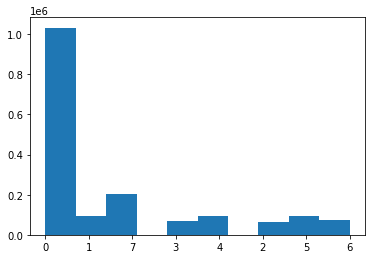

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#plt.hist(pubfile['COST'],bins=[-1000,-500,-100,-10,-5,0,5,10,100,500,1000])
plt.hist(pubfile['CHILDAGE'])


KeyboardInterrupt: 

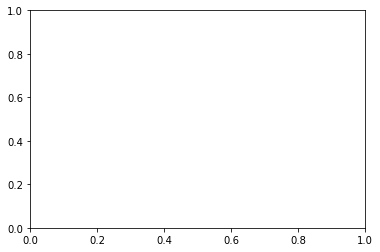

In [81]:
pubfile.CHILDAGE.plot.bar()

In [51]:
#
# Compare to ACS
#
acs = pd.read_csv("D:\\Open Environments\\data\\Open Environments\\blockgroupdemographics\\2019\\2019blockgroupdemographics.csv")

In [53]:
acs.columns

Index(['GEOID', 'B11001e1', 'B11001e2', 'B11001e7', 'B09019e1', 'B09018e1',
       'B19013e1', 'B19001e1', 'B19001e2', 'B19001e3',
       ...
       'MinorityRate', 'PopDensity', 'CollegePlusRate', 'EmploymentRate',
       'FamilyRate', 'ChildrenRate', 'Under25KRate', 'logPop', 'logPopDensity',
       'logLand'],
      dtype='object', length=128)

In [ ]:
THIS RECREATES TABLE 1203 INCOME BEFORE TAXES 

  /***************************************************************************/
  /* PROGRAM NAME:  CEX INTEGRATED SURVEYS SAMPLE PROGRAM (SAS)              */
  /* FUNCTION: CREATE AN INTEGRATED SURVEY EXPENDITURE TABLE BY INCOME CLASS */
  /*           USING MICRODATA FROM THE BUREAU OF LABOR STATISTICS' CONSUMER */
  /*           EXPENDITURE SURVEY.                                           */
  /*                                                                         */
  /* WRITTEN BY: BUREAU OF LABOR STATISTICS         APRIL 7 2003             */
  /*             CONSUMER EXPENDITURE SURVEY                                 */
  /* MODIFICATIONS:                                                          */
  /* DATE-      MODIFIED BY-        REASON-                                  */
  /* -----      ------------        -------                                  */
  /*                                                                         */ 
  /*                                                                         */
  /*                                                                         */
  /*  NOTE:  FOR SAS VERSION 8 OR HIGHER                                     */
  /***************************************************************************/


  /*Enter Data Year*/
    %LET YEAR = 2018;
  /*Enter location of the unzipped microdata file*/
  /*Be sure to keep the same file structure as found online*/
    %LET DRIVE = C:\2018_CEX;


  /***************************************************************************/
  /* STEP1: READ IN THE STUB PARAMETER FILE AND CREATE FORMATS               */
  /* ----------------------------------------------------------------------- */
  /* 1 CONVERTS THE STUB PARAMETER FILE INTO A LABEL FILE FOR OUTPUT         */
  /* 2 CONVERTS THE STUB PARAMETER FILE INTO AN EXPENDITURE AGGREGATION FILE */
  /* 3 CREATES FORMATS FOR USE IN OTHER PROCEDURES                           */
  /***************************************************************************/


%LET YR1 = %SUBSTR(&YEAR, 3, 2);
%LET YR2 = %SUBSTR(%EVAL(&YEAR + 1), 3, 2);
LIBNAME I&YR1 "&DRIVE\INTRVW&YR1";
LIBNAME D&YR1 "&DRIVE\DIARY&YR1";

DATA STUBFILE (KEEP= COUNT TYPE LEVEL TITLE UCC SURVEY GROUP LINE);
  INFILE "C:\2018_CEX\Programs\INTSTUB&YEAR..TXT"
  PAD MISSOVER;
  INPUT @1 TYPE $1. @ 4 LEVEL $1. @7 TITLE $CHAR60. @70 UCC $6.
        @83 SURVEY $1. @89 GROUP $7.;
  IF (TYPE = '1');
  IF GROUP IN ('CUCHARS','FOOD','EXPEND','INCOME');
  
    RETAIN COUNT 9999;
    COUNT + 1;
    LINE = PUT(COUNT, $5.)||LEVEL;
	/* READS IN THE STUB PARAMETER FILE AND CREATES LINE NUMBERS FOR UCCS */
	/* A UNIQUE LINE NUMBER IS ASSIGNED TO EACH EXPENDITURE LINE ITEM     */
RUN;


DATA AGGFMT1 (KEEP= UCC LINE LINE1-LINE10);
  SET STUBFILE;
  LENGTH LINE1-LINE10 $6.;
    ARRAY LINES(9) LINE1-LINE9;
      IF (UCC > 'A') THEN
        LINES(SUBSTR(LINE,6,1)) = LINE;
	  RETAIN LINE1-LINE9;
      IF (UCC < 'A')  THEN 
        LINE10 = LINE;
  IF (LINE10);
  /* MAPS LINE NUMBERS TO UCCS */
RUN;


PROC SORT DATA= AGGFMT1 (RENAME=(LINE= COMPARE));
  BY UCC;
RUN;


PROC TRANSPOSE DATA= AGGFMT1 OUT= AGGFMT2 (RENAME=(COL1= LINE));
  BY UCC COMPARE;
  VAR LINE1-LINE10;
RUN;


DATA AGGFMT (KEEP= UCC LINE);
  SET AGGFMT2;
    IF LINE;
    IF SUBSTR(COMPARE,6,1) > SUBSTR(LINE,6,1) OR COMPARE=LINE;
	/* AGGREGATION FILE. EXTRANEOUS MAPPINGS ARE DELETED */
	/* PROC SQL WILL AGGANGE LINE#/UCC PAIRS FOR USE IN PROC FORMAT */
	
RUN;


PROC SQL NOPRINT;
  SELECT UCC, LINE, COUNT(*)
  INTO  :UCCS SEPARATED BY " ",
        :LINES SEPARATED BY " ",          
        :CNT
  FROM AGGFMT;
  QUIT;
RUN;


%MACRO MAPPING;
  %DO  i = 1  %TO  &CNT;
    "%SCAN(&UCCS,&i,%STR( ))" = "%SCAN(&LINES,&i,%STR( ))"
  %END;
%MEND MAPPING;


DATA LBLFMT (RENAME=(LINE= START TITLE= LABEL));
  SET STUBFILE (KEEP= LINE TITLE);
  RETAIN FMTNAME 'LBLFMT' TYPE 'C';
  /* LABEL FILE. LINE NUMBERS ARE ASSIGNED A TEXT LABEL */
  /* DATASET CONSTRUCTED TO BE READ INTO A PROC FORMAT  */
RUN;


PROC FORMAT;

  VALUE $AGGFMT (MULTILABEL)
    %MAPPING
    OTHER= 'OTHER'
    ;

  VALUE $INC (MULTILABEL)
    '01' = '01'
    '01' = '10'
    '02' = '02'
    '02' = '10'
    '03' = '03'
    '03' = '10'
    '04' = '04'
    '04' = '10'
    '05' = '05'
    '05' = '10'
    '06' = '06'
    '06' = '10'
    '07' = '07'
    '07' = '10'
    '08' = '08'
    '08' = '10'
    '09' = '09'
    '09' = '10';
	/* CREATE INCOME CLASS FORMAT */
RUN;


PROC FORMAT LIBRARY= WORK  CNTLIN= LBLFMT;
RUN;


  /***************************************************************************/
  /* STEP2: READ IN ALL NEEDED DATA                                          */
  /* ----------------------------------------------------------------------- */
  /* 1 READ IN THE INTERVIEW AND DIARY FMLY FILES & CREATE MO_SCOPE VARIABLE */
  /* 2 READ IN THE INTERVIEW MTAB/ITAB AND DIARY EXPN/DTAB FILES             */
  /* 3 MERGE FMLY AND EXPENDITURE FILES TO DERIVE WEIGHTED EXPENDITURES      */
  /***************************************************************************/


DATA FMLY (KEEP= NEWID SOURCE INCLASS WTREP01-WTREP44 FINLWT21 REPWT1-REPWT45);

SET D&YR1..FMLD&YR1.1
    D&YR1..FMLD&YR1.2
    D&YR1..FMLD&YR1.3
    D&YR1..FMLD&YR1.4

    I&YR1..FMLI&YR1.1x (IN=FIRSTQTR)
    I&YR1..FMLI&YR1.2 
    I&YR1..FMLI&YR1.3
    I&YR1..FMLI&YR1.4
    I&YR1..FMLI&YR2.1  (IN= LASTQTR);

	BY NEWID;

    IF FIRSTQTR THEN 
      MO_SCOPE = (QINTRVMO - 1);
    ELSE IF LASTQTR THEN 
      MO_SCOPE = (4 - QINTRVMO);
    ELSE  
      MO_SCOPE = 3;

	
    ARRAY REPS_A(45) WTREP01-WTREP44 FINLWT21;
    ARRAY REPS_B(45) REPWT1-REPWT45;

      DO i = 1 TO 45;
	  IF REPS_A(i) > 0 THEN
         REPS_B(i) = (REPS_A(i) * MO_SCOPE / 12); 
		 ELSE REPS_B(i) = 0;	
	  END;

	  IF QINTRVYR  THEN 
        SOURCE = 'I';
	  IF WEEKI THEN 
        SOURCE = 'D';

/******CREATE VARIABLE INCLASS FOR INTERVIEW SURVEY*********/
	  IF FINCBTXM NE . AND FINCBTXM < 15000 THEN INCLASS = '01';
	  IF 15000 <=  FINCBTXM < 30000 THEN INCLASS = '02';
	  IF 30000 <=  FINCBTXM < 40000 THEN INCLASS = '03';
	  IF 40000 <=  FINCBTXM < 50000 THEN INCLASS = '04';
	  IF 50000 <=  FINCBTXM < 70000 THEN INCLASS = '05';
	  IF 70000 <=  FINCBTXM < 100000 THEN INCLASS = '06';
	  IF 100000 <= FINCBTXM < 150000 THEN INCLASS = '07';
	  IF 150000 <= FINCBTXM < 200000 THEN INCLASS = '08';
	  IF FINCBTXM NE . AND FINCBTXM >= 200000  THEN INCLASS = '09';
/******CREATE VARIABLE INCLASS FOR DIARY SURVEY*********/
	  IF FINCBEFM NE . AND FINCBEFM < 15000 THEN INCLASS = '01';
	  IF 15000 <=  FINCBEFM < 30000 THEN INCLASS = '02';
	  IF 30000 <=  FINCBEFM < 40000 THEN INCLASS = '03';
	  IF 40000 <=  FINCBEFM < 50000 THEN INCLASS = '04';
	  IF 50000 <=  FINCBEFM < 70000 THEN INCLASS = '05';
	  IF 70000 <=  FINCBEFM < 100000 THEN INCLASS = '06';
	  IF 100000 <= FINCBEFM < 150000 THEN INCLASS = '07';
	  IF 150000 <= FINCBEFM < 200000 THEN INCLASS = '08';
	  IF FINCBEFM NE . AND FINCBEFM >= 200000  THEN INCLASS = '09';
	   
RUN;

DATA EXPEND (KEEP= NEWID SOURCE UCC COST REFMO REFYR);

  SET D&YR1..EXPD&YR1.1
      D&YR1..EXPD&YR1.2
      D&YR1..EXPD&YR1.3
      D&YR1..EXPD&YR1.4

      D&YR1..DTBD&YR1.1 (RENAME=(AMOUNT=COST))
      D&YR1..DTBD&YR1.2 (RENAME=(AMOUNT=COST))
      D&YR1..DTBD&YR1.3 (RENAME=(AMOUNT=COST))
      D&YR1..DTBD&YR1.4 (RENAME=(AMOUNT=COST))

      I&YR1..MTBI&YR1.1X
      I&YR1..MTBI&YR1.2
      I&YR1..MTBI&YR1.3
      I&YR1..MTBI&YR1.4
      I&YR1..MTBI&YR2.1

      I&YR1..ITBI&YR1.1X  (RENAME=(VALUE=COST))
      I&YR1..ITBI&YR1.2   (RENAME=(VALUE=COST))
      I&YR1..ITBI&YR1.3   (RENAME=(VALUE=COST))
      I&YR1..ITBI&YR1.4   (RENAME=(VALUE=COST))
      I&YR1..ITBI&YR2.1   (RENAME=(VALUE=COST)); 
  
  IF (PUBFLAG = '2') THEN 
    DO;
		SOURCE = 'I';
        IF (REFYR = "&YEAR") OR  (REF_YR = "&YEAR") THEN 
        OUTPUT;
    END;

  IF (PUB_FLAG = '2') THEN 
    DO;
      SOURCE = 'D';
	  COST = (COST * 13);
      OUTPUT;
    END;
RUN;

PROC SORT DATA=EXPEND;
	BY NEWID;
RUN;

DATA PUBFILE (KEEP= NEWID SOURCE INCLASS UCC RCOST1-RCOST45);
  MERGE FMLY   (IN= INFAM)
        EXPEND (IN= INEXP);
  BY NEWID;
  IF (INEXP AND INFAM);

  IF (COST = .)  THEN 
     COST = 0;
	 
     ARRAY REPS_A(45) WTREP01-WTREP44 FINLWT21;
     ARRAY REPS_B(45) RCOST1-RCOST45;

     DO i = 1 TO 45;
	   IF REPS_A(i) > 0
         THEN REPS_B(i) = (REPS_A(i) * COST);
	     ELSE REPS_B(i) = 0; 	
	 END; 
RUN;



  /***************************************************************************/
  /* STEP3: CALCULATE POPULATIONS                                            */
  /* ----------------------------------------------------------------------- */
  /*  SUM ALL 45 WEIGHT VARIABLES TO DERIVE REPLICATE POPULATIONS            */
  /*  FORMATS FOR CORRECT COLUMN CLASSIFICATIONS                             */
  /***************************************************************************/


PROC SUMMARY NWAY DATA=FMLY SUMSIZE=MAX;
  CLASS INCLASS SOURCE / MLF;
  VAR REPWT1-REPWT45;
  FORMAT INCLASS $INC.;
  OUTPUT OUT = POP (DROP = _TYPE_ _FREQ_) SUM = RPOP1-RPOP45;
RUN;

 

  /***************************************************************************/
  /* STEP4: CALCULATE WEIGHTED AGGREGATE EXPENDITURES                        */
  /* ----------------------------------------------------------------------- */
  /*  SUM THE 45 REPLICATE WEIGHTED EXPENDITURES TO DERIVE AGGREGATES/UCC    */
  /*  FORMATS FOR CORRECT COLUMN CLASSIFICATIONS                             */
  /***************************************************************************/


PROC SUMMARY NWAY DATA=PUBFILE SUMSIZE=MAX COMPLETETYPES;
  CLASS SOURCE UCC INCLASS / MLF;
  VAR RCOST1-RCOST45;
  FORMAT INCLASS $INC.;
   OUTPUT OUT= AGG (DROP= _TYPE_ _FREQ_) 
   SUM= RCOST1-RCOST45;
RUN;



  /***************************************************************************/
  /* STEP5: CALCULTATE MEAN EXPENDITURES                                     */
  /* ----------------------------------------------------------------------- */
  /* 1 READ IN POPULATIONS AND LOAD INTO MEMORY USING A 3 DIMENSIONAL ARRAY  */
  /*   POPULATIONS ARE ASSOCIATED BY INCLASS, SOURCE(t), AND REPLICATE(j)    */
  /* 2 READ IN AGGREGATE EXPENDITURES FROM AGG DATASET                       */
  /* 3 CALCULATE MEANS BY DIVIDING AGGREGATES BY CORRECT SOURCE POPULATIONS  */
  /*   EXPENDITURES SOURCED FROM DIARY ARE CALULATED USING DIARY POPULATIONS */
  /*   WHILE INTRVIEW EXPENDITURES USE INTERVIEW POPULATIONS                 */
  /* 4 SUM EXPENDITURE MEANS PER UCC INTO CORRECT LINE ITEM AGGREGATIONS     */
  /***************************************************************************/


DATA AVGS1 (KEEP = SOURCE INCLASS UCC MEAN1-MEAN45);

  /* READS IN POP DATASET. _TEMPORARY_ LOADS POPULATIONS INTO SYSTEM MEMORY  */
  ARRAY POP{01:10,2,45} _TEMPORARY_ ;
  IF _N_ = 1 THEN DO i = 1 TO 20;
    SET POP;
	ARRAY REPS{45} RPOP1--RPOP45;
	IF SOURCE = 'D' THEN t = 1;
	ELSE t = 2;
	  DO j = 1 TO 45;
	    POP{INCLASS,t,j} = REPS{j};
	  END;
	END;

  /* READS IN AGG DATASET AND CALCULATES MEANS BY DIVIDING BY POPULATIONS  */
  SET AGG (KEEP = UCC INCLASS SOURCE RCOST1-RCOST45);
	IF SOURCE = 'D' THEN t = 1;
	ELSE t = 2;
  ARRAY AGGS(45) RCOST1-RCOST45;
  ARRAY AVGS(45) MEAN1-MEAN45;
	DO k = 1 TO 45;
	  IF AGGS(k) = .  THEN AGGS(k) = 0;
	  AVGS(k) = AGGS(k) / POP{INCLASS,t,k};
	END;
RUN;


PROC SUMMARY DATA=AVGS1 NWAY COMPLETETYPES;
  CLASS INCLASS UCC / MLF;
  VAR MEAN1-MEAN45;
  FORMAT UCC $AGGFMT.;
  OUTPUT OUT=AVGS2 (DROP= _TYPE_ _FREQ_  RENAME=(UCC= LINE)) SUM= ;
  /* SUM UCC MEANS TO CREATE AGGREGATION SCHEME */
RUN;


  /***************************************************************************/
  /* STEP6: CALCULTATE STANDARD ERRORS                                       */
  /* ----------------------------------------------------------------------- */
  /*  CALCULATE STANDARD ERRORS USING REPLICATE FORMULA                      */
  /***************************************************************************/


DATA SE (KEEP = INCLASS LINE MEAN SE);
  SET AVGS2;
  ARRAY RMNS(44) MEAN1-MEAN44;
  ARRAY DIFF(44) DIFF1-DIFF44;
    DO i = 1 TO 44;
      DIFF(i) = (RMNS(i) - MEAN45)**2;
    END;
  MEAN = MEAN45;
  SE = SQRT((1/44)*SUM(OF DIFF(*)));
RUN;


  /***************************************************************************/
  /* STEP7: TABULATE EXPENDITURES                                            */
  /* ----------------------------------------------------------------------- */
  /* 1 ARRANGE DATA INTO TABULAR FORM                                        */
  /* 2 SET OUT INTERVIEW POPULATIONS FOR POPULATION LINE ITEM                */
  /* 3 INSERT POPULATION LINE INTO TABLE                                     */
  /* 4 INSERT ZERO EXPENDITURE LINE ITEMS INTO TABLE FOR COMPLETENESS        */
  /***************************************************************************/


PROC SORT DATA=SE;
  BY LINE INCLASS;

PROC TRANSPOSE DATA=SE OUT=TAB1
  NAME = ESTIMATE PREFIX = INCLASS;
  BY LINE;
  VAR MEAN SE;
  /*ARRANGE DATA INTO TABULAR FORM */
RUN;


PROC TRANSPOSE DATA=POP (KEEP = SOURCE RPOP45) OUT=CUS
  NAME = LINE PREFIX = INCLASS;
  VAR RPOP45;
  WHERE SOURCE = 'I';
  /* SET ASIDE POPULATIONS FROM INTERVIEW */
RUN;


DATA TAB2;
  SET CUS TAB1;
  IF LINE = 'RPOP45' THEN DO;
    LINE = '100001';
	ESTIMATE = 'N';
	END;
  /* INSERT POPULATION LINE ITEM INTO TABLE AND ASSIGN LINE NUMBER */
RUN;

PROC SORT DATA=TAB2; 
	BY LINE;
RUN;


DATA TAB;
  MERGE TAB2 STUBFILE;
  BY LINE;
    IF LINE NE '100001' THEN DO;
	  IF SURVEY = 'S' THEN DELETE;
	END;
	ARRAY CNTRL(10) INCLASS1-INCLASS10;
	  DO i = 1 TO 10;
	    IF CNTRL(i) = . THEN CNTRL(i) = 0;
		IF SUM(OF CNTRL(*)) = 0 THEN ESTIMATE = 'MEAN';
	  END;

	IF GROUP IN ('CUCHARS' 'INCOME') THEN DO;
	  IF LAG(LINE) = LINE THEN DELETE;
	END;
	IF TITLE = "Percent distribution:" THEN DELETE;
  /* MERGE STUBFILE BACK INTO TABLE TO INSERT EXPENDITURE LINES */
  /* THAT HAD ZERO EXPENDITURES FOR THE YEAR     
*/
	IF SURVEY = 'T' THEN DELETE;
RUN;


PROC TABULATE DATA=TAB;
  CLASS LINE / GROUPINTERNAL ORDER=DATA;
  CLASS ESTIMATE;
  VAR INCLASS1-INCLASS10;
  FORMAT LINE $LBLFMT.;

    TABLE (LINE * ESTIMATE), (INCLASS10 INCLASS1 INCLASS2 INCLASS3 INCLASS4 
                              INCLASS5  INCLASS6 INCLASS7 INCLASS8 INCLASS9) 
    *SUM='' / RTS=25;
    LABEL ESTIMATE=ESTIMATE LINE=LINE
		  INCLASS1='LESS THAN $15,000'    INCLASS2='$15,000 TO $29,999' 
          INCLASS3='$30,000 TO $39,999'   INCLASS4='$40,000 TO $49,999'
          INCLASS5='$50,000 TO $69,999'   INCLASS6='$70,000 TO $99,999'
          INCLASS7='$100,000 TO $149,999' INCLASS8='$150,000 TO $199,999'
          INCLASS9='$200,000 AND OVER'    INCLASS10='ALL CONSUMER UNITS';	
	OPTIONS NODATE NOCENTER NONUMBER LS=167 PS=MAX;
	WHERE LINE NE 'OTHER';
    TITLE "INTEGRATED EXPENDITURES FOR &YEAR BY INCOME BEFORE TAXES";
RUN;
